## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Device Configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyper Parameters

In [3]:
num_epochs = 10
batch_size = 8
learning_rate = 0.001

## Apply needed transforms on data
#### The dataset has PILImage images of range [0,1]
#### We transform them to Tensors of normalized range[-1, 1]

## Load Data

In [4]:
train_dataset = datasets.CIFAR10(root='dataset', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='dataset', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Define Dataset Classes

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Lets visualize few data images

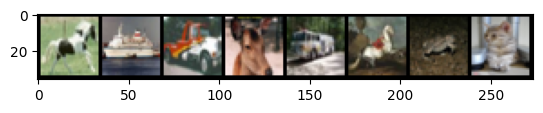

In [6]:
def imshow(img):
    img = img   # or xunnormalize by img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))

## Create CNN Model

#### Input -> Convolution -> Relu -> MaxPool -> Convolution -> Relu -> MaxPool -> FC -> FC -> FC -> Softmax

In [7]:
## Visualizing each operation values
conv1 = nn.Conv2d(3,6,5)
pool1 = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6,16,5)
pool2 = nn.MaxPool2d(2,2)
print('image shape : ', images.shape)   # (batch_size, channel, H, W)
x = conv1(images)
print('conv1 shape', x.shape)   # (n-f+2p/s) + 1 -> (32-5+0)/1 + 1 =28
x = pool1(x)
print('pool1 shape', x.shape)   # (28-2+0)/2 +1 = 14
x = conv2(x)
print('conv2 shape', x.shape)   # (14-5+0)/1 + 1 = 10
x = pool2(x)
print('pool2 shape', x.shape)   # (10-2+0)/2 + 1 = 5; 

## This last layer output is taken as input for FC

image shape :  torch.Size([8, 3, 32, 32])
conv1 shape torch.Size([8, 6, 28, 28])
pool1 shape torch.Size([8, 6, 14, 14])
conv2 shape torch.Size([8, 16, 10, 10])
pool2 shape torch.Size([8, 16, 5, 5])


In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,kernel_size=5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self,x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        # To pass this activated output to FC, we need to flatten it
        x = x.view(-1, 16*5*5)    #-1:automatically find correct size(here, its no.of samples)
        
        #Lets call 1st FC layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)          #No activation function at the output, also no softmax as its already included in criterion loss
        return x


## Initialize Model

In [9]:
model = ConvNet().to(device)

## Loss and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train Network

In [11]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #Backward and Optimize 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss : {loss.item():.4f}')
                  
print('Finished Training')

Epoch [1/10], Step [1500/6250], Loss : 2.3108
Epoch [1/10], Step [3000/6250], Loss : 2.3001
Epoch [1/10], Step [4500/6250], Loss : 2.2935
Epoch [1/10], Step [6000/6250], Loss : 2.3011
Epoch [2/10], Step [1500/6250], Loss : 2.2885
Epoch [2/10], Step [3000/6250], Loss : 2.2940
Epoch [2/10], Step [4500/6250], Loss : 2.2872
Epoch [2/10], Step [6000/6250], Loss : 2.2566
Epoch [3/10], Step [1500/6250], Loss : 2.2827
Epoch [3/10], Step [3000/6250], Loss : 2.2224
Epoch [3/10], Step [4500/6250], Loss : 2.1575
Epoch [3/10], Step [6000/6250], Loss : 2.2635
Epoch [4/10], Step [1500/6250], Loss : 2.3306
Epoch [4/10], Step [3000/6250], Loss : 1.9602
Epoch [4/10], Step [4500/6250], Loss : 1.7148
Epoch [4/10], Step [6000/6250], Loss : 2.1265
Epoch [5/10], Step [1500/6250], Loss : 2.9131
Epoch [5/10], Step [3000/6250], Loss : 2.7280
Epoch [5/10], Step [4500/6250], Loss : 1.6302
Epoch [5/10], Step [6000/6250], Loss : 2.1941
Epoch [6/10], Step [1500/6250], Loss : 2.2176
Epoch [6/10], Step [3000/6250], Lo

## Check Accuracy

In [12]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network : {acc} % ')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]} : {acc} %')

Accuracy of the network : 45.01 % 
Accuracy of plane : 36.7 %
Accuracy of car : 67.5 %
Accuracy of bird : 25.5 %
Accuracy of cat : 23.8 %
Accuracy of deer : 37.8 %
Accuracy of dog : 31.6 %
Accuracy of frog : 63.4 %
Accuracy of horse : 46.1 %
Accuracy of ship : 60.9 %
Accuracy of truck : 56.8 %
